# Import Packages

In [ ]:
try:
  import tension
except ImportError:
  !git clone https://github.com/zhenruiliao/tension.git tension
  !pip install -e tension
  print('Stopping RUNTIME! Please run again.')
  import os
  os.kill(os.getpid(), 9)



In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

from tension.constrained import ConstrainedNoFeedbackESN, BioFORCEModel

# Load Data

Download `zebrafish-imaging-1.npz` from https://data.mendeley.com/datasets/9936ryd5h7/2. This dataset used in [this paper](https://www.sciencedirect.com/science/article/abs/pii/S0896627321004220). 

In [ ]:
!wget https://data.mendeley.com/public-files/datasets/9936ryd5h7/files/7ac6616e-b6f7-4773-b254-b088147f68e6/file_downloaded 

--2022-07-02 20:52:09--  https://data.mendeley.com/public-files/datasets/9936ryd5h7/files/7ac6616e-b6f7-4773-b254-b088147f68e6/file_downloaded
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/944fd3b3-cdd4-490d-a588-16392c862770 [following]
--2022-07-02 20:52:10--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/944fd3b3-cdd4-490d-a588-16392c862770
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.88.216
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.88.216|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 224252686 (214M) [applicati

In [ ]:
with np.load('file_downloaded', allow_pickle=True) as data:
  keys = ['mask_name', 'cell_ids', 'tracez', 'all_coords']
  i = -4 # index corresponding to desired data 
  cell_id = list(data['cell_ids'])[i]  
  print(data['mask_name'][i])
  print(data['tracez'].shape)
  print(data['tracez'][cell_id].shape) 
  target = data['tracez'][cell_id] # based on cell_id's of neurons in desired area of brain

Telencephalon - Subpallium
(11190, 2500)
(365, 2500)


# Define training parameters

In [ ]:
target_transposed = np.transpose(target).astype(np.float32) # convert to shape (timestep, number of neurons)
target_transposed.shape

(2500, 365)

In [ ]:
u = 1 # number of inputs, by default the forward pass does not use inputs so this is a stand-in
n = target_transposed.shape[1] # number of neurons
tau = 1.5 # neuron time constant
dt = 0.25 # time step
alpha = 1 # gain on P matrix at initialization
m = n # output dim equals the number of recurrent neurons
g = 1.25 # gain parameter controlling network chaos
p_recurr = 0.5 # (1 - p_recurr) of recurrent weights are randomly set to 0 and not trained
max_epoch = 100

structural_connectivity = np.ones((n, n)) # region connectivity matrix; set to all 1's since only looking at one subsection of the brain
noise_param = (0, 0.001) # mean and std of white noise injected to the forward pass

x_t = np.zeros((target_transposed.shape[0], u)).astype(np.float32) # stand-in input

# Define custom callback

Define a custom callback for performing early stopping once the validation error is below a certain value

In [ ]:
class EarlyStoppingByLossVal(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super().__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        
        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

# Instantiate the network and train the model

**NOTE:** The following cell will take approximately 10-15 minutes on Google Colab's GPU

In [ ]:
%%time
tf.random.set_seed(123)

earlystopping = EarlyStoppingByLossVal(monitor="val_mae", value=0.25)
esn_layer = ConstrainedNoFeedbackESN(units=n,
                                     activation='tanh',
                                     dtdivtau=dt/tau,
                                     p_recurr=p_recurr,
                                     structural_connectivity=structural_connectivity,
                                     noise_param=noise_param,
                                     seed=123)

model = BioFORCEModel(force_layer=esn_layer, alpha_P=alpha)
model.compile(metrics=["mae"])

# pass the input as validation data for early stopping
history = model.fit(x=x_t, 
                    y=target_transposed, 
                    epochs=max_epoch,
                    callbacks=[earlystopping],
                    validation_data=(x_t, target_transposed))

Epoch 1/100
2500/2500 [==============================] - 32s 11ms/step - mae: 0.5839 - val_loss: 1.5869 - val_mae: 1.5869
Epoch 2/100
2500/2500 [==============================] - 29s 12ms/step - mae: 0.3443 - val_loss: 1.2197 - val_mae: 1.2197
Epoch 3/100
2500/2500 [==============================] - 30s 12ms/step - mae: 0.2948 - val_loss: 0.9802 - val_mae: 0.9802
Epoch 4/100
2500/2500 [==============================] - 30s 12ms/step - mae: 0.2773 - val_loss: 1.0299 - val_mae: 1.0299
Epoch 5/100
2500/2500 [==============================] - 29s 11ms/step - mae: 0.2528 - val_loss: 1.0820 - val_mae: 1.0820
Epoch 6/100
2500/2500 [==============================] - 30s 12ms/step - mae: 0.2682 - val_loss: 1.0270 - val_mae: 1.0270
Epoch 7/100
2500/2500 [==============================] - 28s 11ms/step - mae: 0.2392 - val_loss: 0.9084 - val_mae: 0.9084
Epoch 8/100
2500/2500 [==============================] - 30s 12ms/step - mae: 0.2305 - val_loss: 0.6750 - val_mae: 0.6750
Epoch 9/100
2500/2500 [=

# Run Inference

Note that due to the noise injected in the forward pass, output will change when re-running this cell

In [ ]:
%%time
prediction = model.predict(x_t)
print(tf.math.reduce_mean(tf.keras.metrics.mean_absolute_error(prediction, target_transposed)))

tf.Tensor(0.23826978, shape=(), dtype=float32)
CPU times: user 3.73 s, sys: 313 ms, total: 4.05 s
Wall time: 14.7 s


# Plot target and prediction for 5 neurons

Text(0.5, 0, 'Time (s)')

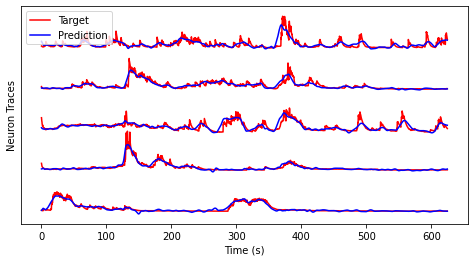

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (8,4))
num_plot = [5, 20, 48, 92, 264] # select 5 neurons for plotting

for idx, i in enumerate(num_plot):
  ax.plot(np.arange(0, x_t.shape[0]) * dt, target_transposed[:,i] + 10 * idx, color='r')
  ax.plot(np.arange(0, x_t.shape[0]) * dt, prediction[:,i] + 10 * idx, color='b')
  if i == num_plot[-1]:
    ax.legend(['Target', 'Prediction'])
ax.set_yticks([])
ax.set_ylabel('Neuron Traces')
ax.set_xlabel('Time (s)')

# Comparing prediction and target after PCA dimension reduction

Text(0, 0.5, 'PC2')

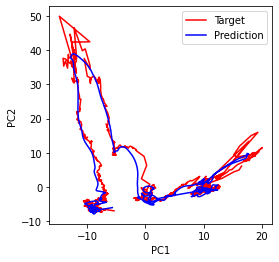

In [ ]:
assert prediction.shape == target_transposed.shape
pca = PCA(n_components=2)
target_pca = pca.fit_transform(target_transposed)
pred_pca = pca.transform(prediction)
assert target_pca.shape == pred_pca.shape

plt.figure(figsize=(4,4))
plt.plot(target_pca[:,0], target_pca[:,1], color='r', label='Target')
plt.plot(pred_pca[:,0], pred_pca[:,1], color='b', label='Prediction')
plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')